In [1]:
from datetime import datetime
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "svg"

layout = {
    'showlegend': True,
    'margin': {'b':10, 'l':20, 'r':50, 't':50},
    'font': {'size': 19},
    'xaxis': {'zerolinewidth': 2, 'zerolinecolor':'black'},
    'yaxis': {'zerolinewidth': 2, 'zerolinecolor':'black'},
    'template': 'plotly_white',
}

px.defaults.color_discrete_sequence = px.colors.qualitative.T10

# Import REFIT data
Collection of this dataset was supported by the Engineering and Physical Sciences Research Council (EPSRC) via the project entitled Personalised Retrofit Decision Support Tools for UK Homes using Smart Home Technology (REFIT), which is a collaboration among the Universities of Strathclyde, Loughborough and East Anglia. The dataset includes data from 20 households from the Loughborough area over the period 2013 - 2014. Additional information about REFIT is available from www.refitsmarthomes.org

MISSING DATA
During the course of the study there are a few periods of missing data (notably February 2014). Outages were due to a number of factors, including household internet failure, hardware failures, network routing issues, etc.

Household Information
House, Occupancy, Construction Year, Appliances Owned, Type, Size
1	,	2	,	1975-1980				, 35 , Detached			, 4 bed
2	,	4	,	-						, 15 , Semi-detached	, 3 bed
3	,	2	,	1988					, 27 , Detached			, 3 bed
4	,	2	,	1850-1899 				, 33 , Detached			, 4 bed
5	,	4	,	1878					, 44 , Mid-terrace		, 4 bed
6	,	2	,	2005					, 49 , Detached			, 4 bed
7	,	4	,	1965-1974				, 25 , Detached			, 3 bed
8	,	2	,	1966					, 35 , Detached			, 2 bed
9	,	2	,	1919-1944				, 24 , Detached			, 3 bed
10	,	4	,	1919-1944				, 31 , Detached			, 3 bed
11	,	1	,	1945-1964				, 25 , Detached			, 3 bed
12	,	3	,	1991-1995				, 26 , Detached			, 3 bed
13	,	4	,	post 2002				, 28 , Detached			, 4 bed
15	,	1	,	1965-1974				, 19 , Semi-detached	, 3 bed
16	,	6	,	1981-1990				, 48 , Detached			, 5 bed
17	,	3	,	mid 60s					, 22 , Detached			, 3 bed
18	,	2	,	1965-1974				, 34 , Detached			, 3 bed
19	,	4	,	1945-1964				, 26 , Semi-detached	, 3 bed
20	,	2	,	1965-1974				, 39 , Detached			, 3 bed
21	,	4	,	1981-1990				, 23 , Detached			, 3 bed

(To run, comment `%%script false --no-raise-error`)

In [20]:
%%script false --no-raise-error
# remove 3, 11, 21 (because solar counted as loading), no 14 
houses = [1, 2, 4, 5, 6, 7, 8, 9, 10, 12, 13, 15, 16, 17, 18, 19, 20]
path = "../../../archives/GITLAB_olderwork_pesgm_2020/CLEAN_REFIT_081116/"
refit = pd.DataFrame()

for house in houses:
    raw = pd.read_csv(path + 'CLEAN_House' + str(house) + '.csv', parse_dates=[0], index_col=0)
    raw = raw.loc['2014-04-30 23:00:00':'2015-05-01 00:00:00', :]
    
    # Save agg consumption
    raw['AggE'] = raw['Aggregate'].cumsum(axis=0) * 8 / 3600  # sum power every 8 seconds to kWh
    refit['house' + str(house) + '_kW'] = raw['AggE'].resample('5T').last().diff() * 60 / 5 / 1000
refit = refit.resample('5T').interpolate('time')
refit = refit.loc['2014-05-01 00:00:00':'2015-05-01 00:00:00', :]

# --------------------------------------------
dateparse = lambda x: datetime.strptime(x, '%Y%m%d:%H%M')
pv = pd.read_csv("Timeseries_52.772_-1.206_SA_1kWp_crystSi_14_40deg_-4deg_2014_2015.csv",
                 parse_dates=[0], index_col=[0], header=8, skipfooter=13, engine='python',
                 date_parser=dateparse)
# P is in W for a 1kW PV so we just have to change it to kW to get the coef 
pv = pv[['P']] / 1000
pv.columns = ["pv_1kw"]
pv = pv.loc['2014-05-01 00:00:00':'2015-05-01 00:11:00', :]

# Shifting things by 11 min, but whatever.
pv['Index'] = pd.date_range(start='2014-05-01 00:00:00',
                            end='2015-05-01 00:00:00', freq='60T')
pv.set_index('Index', drop=True, inplace=True)

# Interpolating to get 15-min interval values
pv = pv.resample('5T').interpolate('time')
pv.drop(pv.tail(1).index, inplace=True)

# --------------------------------------------
df = refit.copy()
df["pv_1kw"] = pv["pv_1kw"]
df.to_pickle("uk_refit_data_loughborough.pickle")

In [21]:
df = pd.read_pickle("uk_refit_data_loughborough.pickle")
df.head()

,house1_kW,house2_kW,house4_kW,house5_kW,house6_kW,house7_kW,house8_kW,house9_kW,house10_kW,house12_kW,house13_kW,house15_kW,house16_kW,house17_kW,house18_kW,house19_kW,house20_kW,pv_1kw
Time,,,,,,,,,,,,,,,,,,
2014-05-01 00:00:00,0.170453,0.179227,0.295360,0.261973,0.444800,0.111520,0.215920,0.219147,0.378640,0.193787,0.263600,0.193173,0.555440,0.094187,0.172773,0.208000,0.218053,0.0
2014-05-01 00:05:00,0.277760,0.194400,0.342880,0.350507,0.302587,0.173227,0.185947,0.225707,0.298080,0.186507,0.250107,0.216827,0.480560,0.108507,0.148080,0.177493,0.191893,0.0
2014-05-01 00:10:00,0.359360,0.210427,0.237733,0.345093,0.316400,0.337493,0.244853,0.225253,0.307680,0.190560,0.299867,0.229280,0.552453,0.394800,0.199333,0.206187,0.260507,0.0
2014-05-01 00:15:00,0.332187,0.209333,0.123040,0.303040,0.320987,0.253307,0.770213,0.262053,0.306827,0.194400,0.321413,0.226453,0.592853,0.406773,0.250960,0.198640,0.281467,0.0
2014-05-01 00:20:00,0.221067,0.204480,0.157360,0.244427,0.239840,0.205360,0.912400,0.260427,0.306267,0.191120,0.227680,0.193093,0.555947,0.335813,0.200080,0.199867,0.167440,0.0


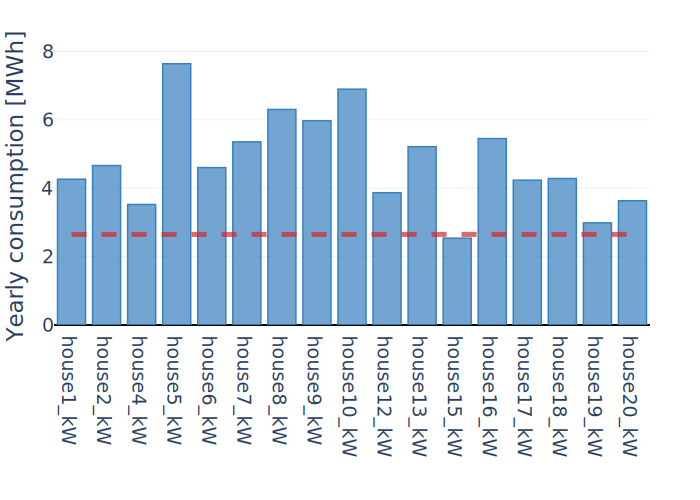

In [22]:
graph = df[[col for col in df.columns if "pv_1kw" not in col]].copy()
fig = px.bar(graph.sum() * 5 /60 / 1000)
fig.data[0].update(
    {'marker': {'color': 'rgba(55, 128, 191, 0.7)',
                'line': {'width': 1.5,
                'color': 'rgba(55, 128, 191, 1.0)'}}})

# 'Reference for 100m2, 4 people, no elec. heating'
fig.add_shape(
  type='line',
  y0=2650/1000, y1=2650/1000, x0="house1_kW", x1="house20_kW",
  line={'dash': 'dash', 'width': 5,
        'color': 'rgba(214, 39, 40, 0.7)'})

fig.update_layout(
    layout,
    showlegend=False,
    xaxis_title="",
    yaxis_title="Yearly consumption [MWh]")
fig.show()

# Set study on house #7

In [23]:
df = df[["house7_kW", "pv_1kw"]]
df.head() 

,house7_kW,pv_1kw
Time,,
2014-05-01 00:00:00,0.111520,0.0
2014-05-01 00:05:00,0.173227,0.0
2014-05-01 00:10:00,0.337493,0.0
2014-05-01 00:15:00,0.253307,0.0
2014-05-01 00:20:00,0.205360,0.0


In [24]:
df.describe().T[["mean", "min", "max"]]

,mean,min,max
house7_kW,0.611387,0.002693,9.763493
pv_1kw,0.112568,0.000000,0.863380


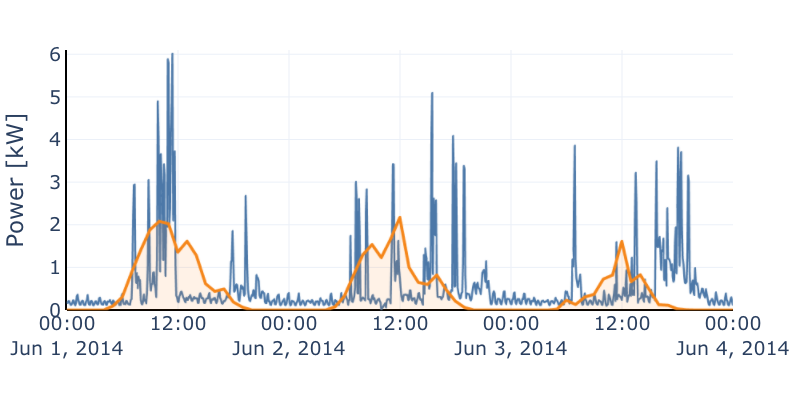

In [26]:
graph = df.loc["2014-06-01 00:00:00":"2014-06-04 00:00:00", :].copy()
graph.pv_1kw *= 3
fig = px.line(graph)
fig.data[1].update(fill="tozeroy", line_width=3,
                   fillcolor="rgba(255, 127, 14, 0.1)")
fig.update_layout(
    layout,
    height=400,
    width=800,
    showlegend=False,
    xaxis_title="",
    yaxis_title="Power [kW]",
    yaxis_showline=True, yaxis_linewidth=2, yaxis_linecolor='black',
    xaxis_showline=False, xaxis_linewidth=2, xaxis_linecolor='black',
    yaxis_range=[0, 6.1])
fig.show(renderer="png")

In [8]:
fig.write_image("results/sample_refit_pvgis.svg")

# Experiment with self-sufficiency at different time intervals

In [10]:
# TEST
graph = df.copy()
df[["house7_kW", "pv_1kw"]].groupby(pd.Grouper(freq="365D")).sum()

,house7_kW,pv_1kw
Time,,
2014-05-01,64268.961413,11833.14948


In [11]:
def self_consumption_production(df, cons_col, prod_col, timing):
    """Return self-consumption and self-production in %"""
    result = {}
    local = df[[cons_col, prod_col]].groupby(pd.Grouper(freq=timing)).sum().min(axis=1).sum()  # unit do not matter
    result[f"self_cons"] = local * 100 / df[prod_col].sum()
    result[f"self_prod"] = local * 100 / df[cons_col].sum()
    return result

In [12]:
pv_sizes = list(np.linspace(0.1, 5, 100))
self_prod = {}
for timing in ["5T", "15T", "30T", "60T", "D", "W", "M", "365D"]:
    self_prod[timing] = []
    for pv_size in pv_sizes:
        graph = df.copy()
        graph.pv_1kw *= pv_size
        res = self_consumption_production(graph, cons_col="house7_kW", prod_col="pv_1kw", timing=timing)
        self_prod[timing].append(res['self_prod'])

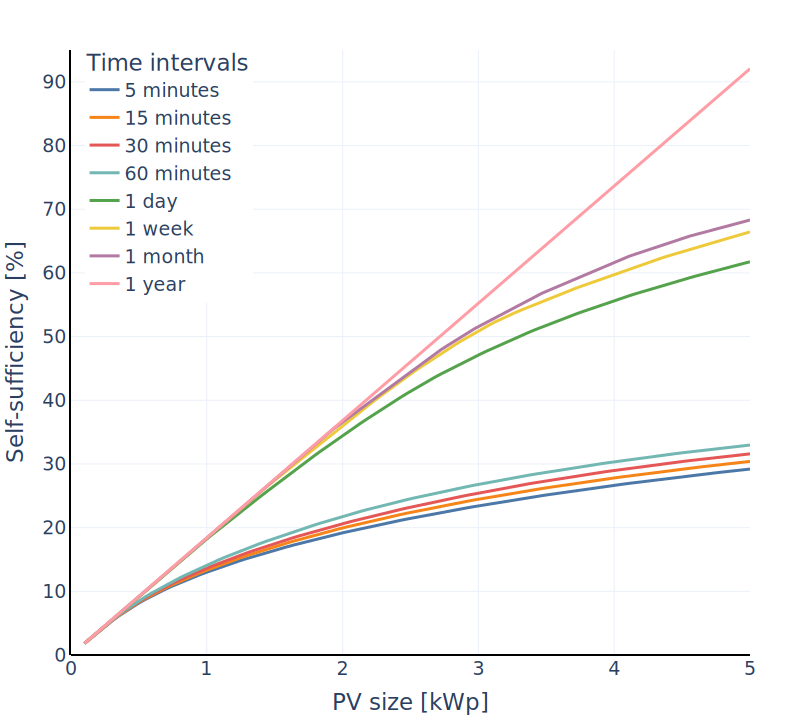

In [13]:
graph = pd.DataFrame(index=pv_sizes, data=self_prod)
graph.columns = ["5 minutes", "15 minutes", "30 minutes", "60 minutes", "1 day", "1 week", "1 month", "1 year"]
fig = px.line(graph)
fig.update_traces(line_width=3)
fig.update_layout(
    layout,
    height=720,
    width=800,
    yaxis_title="Self-sufficiency [%]",
    yaxis_dtick=10,
    xaxis_title="PV size [kWp]",
    yaxis_showline=True, yaxis_linewidth=2, yaxis_linecolor='black',
    xaxis_showline=False, xaxis_linewidth=2, xaxis_linecolor='black',
    yaxis_range=[0, 95],
    xaxis_range=[0, 5],
    showlegend=True,
    legend={"x": 0.02, "y": 1.015},
    legend_title="Time intervals")
fig.show()

In [13]:
fig.write_image("results/self_cons_intervals.svg")

# Experiment with adding storage in self-sufficiency metrics

In [14]:
def def1_self_production(df, cons_col, prod_col, storage):
    """
    Defintion 1: Merge storage in production.
    """
    result = {}
    _df = df.copy()
    _df["prod_before_storage"] = _df[prod_col]
    _df[prod_col] = _df[prod_col] - _df[storage]
    
    local = _df[[cons_col, prod_col]].min(axis=1).sum()  # unit do not matter 
    result[f"self_prod"] = local * 100 / _df[cons_col].sum()
    result[f"self_cons"] = local * 100 / _df["prod_before_storage"].sum()
    return result

def def2_self_production(df, cons_col, prod_col, storage):
    """
    Defintion 2: Merge storage in production and consumption.
    """
    result = {}
    _df = df.copy()
    _df["cons_before_storage"] = _df[cons_col]
    _df["prod_before_storage"] = _df[prod_col]
    _df[prod_col] = _df[prod_col] - _df[storage].clip(upper=0)
    _df[cons_col] = _df[cons_col] + _df[storage].clip(lower=0)
    
    local = _df[[cons_col, prod_col]].min(axis=1).sum()  # unit do not matter
    result[f"self_prod"] = local * 100 / _df["cons_before_storage"].sum()
    result[f"self_cons"] = local * 100 / _df["prod_before_storage"].sum()
    return result

def def3_self_production(df, cons_col, prod_col, storage):
    """
    Defintion 3: Merge storage in consumption and production + denominator with storage.
    """
    result = {}
    _df = df.copy()
    _df[prod_col] = _df[prod_col] - _df[storage].clip(upper=0)
    _df[cons_col] = _df[cons_col] + _df[storage].clip(lower=0)
    
    local = _df[[cons_col, prod_col]].min(axis=1).sum()  # unit do not matter
    result[f"self_prod"] = local * 100 / _df[cons_col].sum()
    result[f"self_cons"] = local * 100 / _df[prod_col].sum()
    return result

def def4_self_production(df, cons_col, prod_col, storage):
    """
    Defintion 4: grid imports / total demand.
    """
    result = {}
    _df = df.copy()
    _df["cons_before_storage"] = _df[cons_col]
    _df["prod_before_storage"] = _df[prod_col]
    _df[prod_col] = _df[prod_col] - _df[storage].clip(upper=0)
    _df[cons_col] = _df[cons_col] + _df[storage].clip(lower=0)
    
    local = _df[[cons_col, prod_col]].min(axis=1).sum()  # unit do not matter
    imports = _df["cons_before_storage"].sum() - local
    export = _df["prod_before_storage"].sum() - local
    result[f"self_prod"] = 100 - (imports * 100 / _df["cons_before_storage"].sum())
    result[f"self_cons"] = 100 - (export * 100 / _df["prod_before_storage"].sum())
    return result

def self_production_1year(df, cons_col, prod_col, storage, timing="365D"):
    """Return self-consumption and self-production in %"""
    result = {}
    local = df[[cons_col, prod_col]].groupby(pd.Grouper(freq=timing)).sum().min(axis=1).sum()  # unit do not matter
    result[f"self_cons"] = local * 100 / df[prod_col].sum()
    result[f"self_prod"] = local * 100 / df[cons_col].sum()
    return result

def self_production(df, cons_col, prod_col, storage):
    """Return self-consumption and self-production in %"""
    result = {}
    local = df[[cons_col, prod_col]].min(axis=1).sum()  # unit do not matter
    result[f"self_prod"] = local * 100 / df[cons_col].sum()
    result[f"self_cons"] = local * 100 / df[prod_col].sum()
    return result

# Scenario "arbitrage"

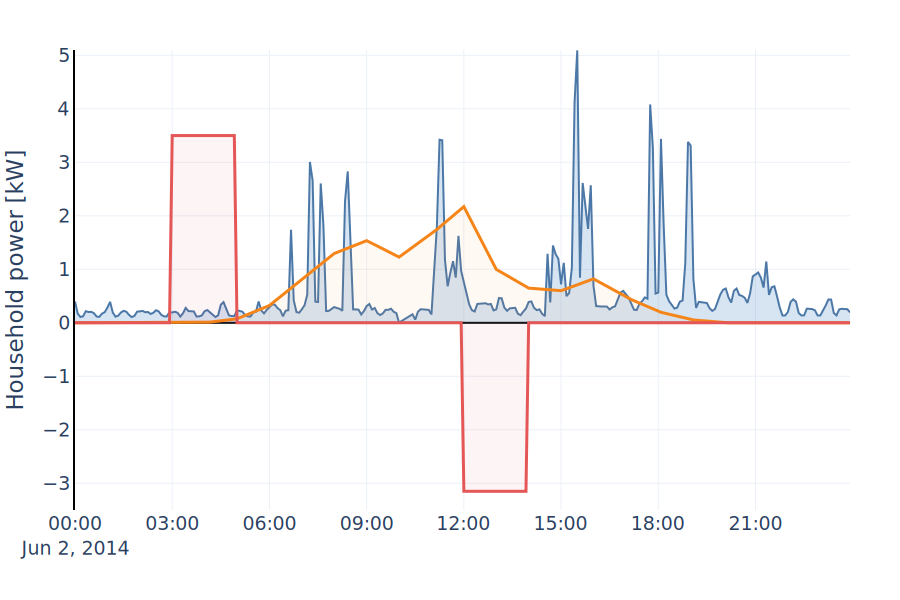

In [15]:
df = df.loc["2014-06-02 00:00:00":"2014-06-02 23:55:00", :]

scenario = df.copy()
scenario.pv_1kw *= 3
scenario["storage"] = 0
scenario.loc["2014-06-02 03:00:00":"2014-06-02 04:55:00", "storage"] = 3.5
#scenario.loc["2014-06-02 14:00:00":"2014-06-02 14:55:00", "storage"] = 0
scenario.loc["2014-06-02 12:00:00":"2014-06-02 13:55:00", "storage"] = -3.5 * 0.9
#scenario.loc["2014-06-02 21:50:00":, "storage"] = -scenario.loc["2014-06-02 21:50:00":, "house7_kW"]

fig = px.line(scenario)
fig.data[0].update(fill="tozeroy", line_width=2,
                   fillcolor="rgba(55, 128, 191, 0.2)")
fig.data[1].update(fill="tozeroy", line_width=3,
                   fillcolor="rgba(255, 127, 14, 0.05)")
fig.data[2].update(fill="tozeroy", line_width=3,
                   fillcolor="rgba(214, 39, 40, 0.05)")
fig.update_layout(
    layout,
    height=600,
    width=900,
    showlegend=False,
    xaxis_title="",
    yaxis_title="Household power [kW]",
    yaxis_showline=True, yaxis_linewidth=2, yaxis_linecolor='black',
    xaxis_showline=False, xaxis_linewidth=2, xaxis_linecolor='black',
    yaxis_range=[-3.5, 5.1])
fig.show()

In [37]:
fig.write_image("results/self_suff_test_day1.svg")

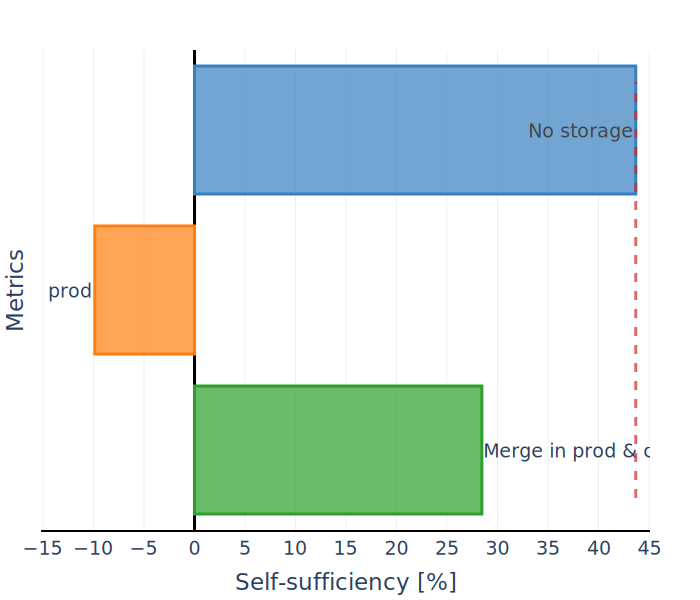

In [16]:
index = ["No storage", "Merge in prod",
         "Merge in prod & cons + denominator"]
funcs = [self_production, def1_self_production,
         def3_self_production]
result = {"self-production": [], "self-consumption": []}
for func in funcs:
    res = func(scenario, "house7_kW", "pv_1kw", "storage")
    result["self-production"].append(res["self_prod"])
    result["self-consumption"].append(res["self_cons"])

result.update({"name": index})    
graph = pd.DataFrame(index=[3, 2, 1], data=result)
#graph = graph.sort_index(ascending=False)
fig = px.bar(graph[["name", "self-production"]],
             x="self-production", text="name", color="name",
             orientation="h")
colors = [("rgba(55, 128, 191, 1.0)", "rgba(55, 128, 191, 0.7)"), 
          ("rgba(255, 127, 14, 1.0)", "rgba(255, 127, 14, 0.7)"),
         ("rgba(44, 160, 44, 1.0)", "rgba(44, 160, 44, 0.7)")]
for i, color in enumerate(colors):
    fig.data[i].update(
        {'marker': {'color': color[1],
                    'line': {'width': 3,
                    'color': color[0]}}})

fig.add_shape(
  type='line',
  x0=graph.loc[3, "self-production"], x1=graph.loc[3, "self-production"],
  y0=0.7, y1=3.3,
  line={'dash': 'dash', 'width': 3,
        'color': 'rgba(214, 39, 40, 0.7)'})
fig.update_layout(
    layout,
    height=600,
    width=700,
    showlegend=False,
    xaxis_title="Self-sufficiency [%]", xaxis_dtick=5,
    yaxis_title="Metrics", yaxis_dtick=10,
    xaxis_showline=True, xaxis_linewidth=2, xaxis_linecolor='black',
    yaxis_showline=False, xaxis_zerolinewidth=3, xaxis_range=[-15.2, 45.1]
)
fig.show()

In [41]:
fig.write_image("results/self_suff_comparison1.svg")

# Scenario "too much"

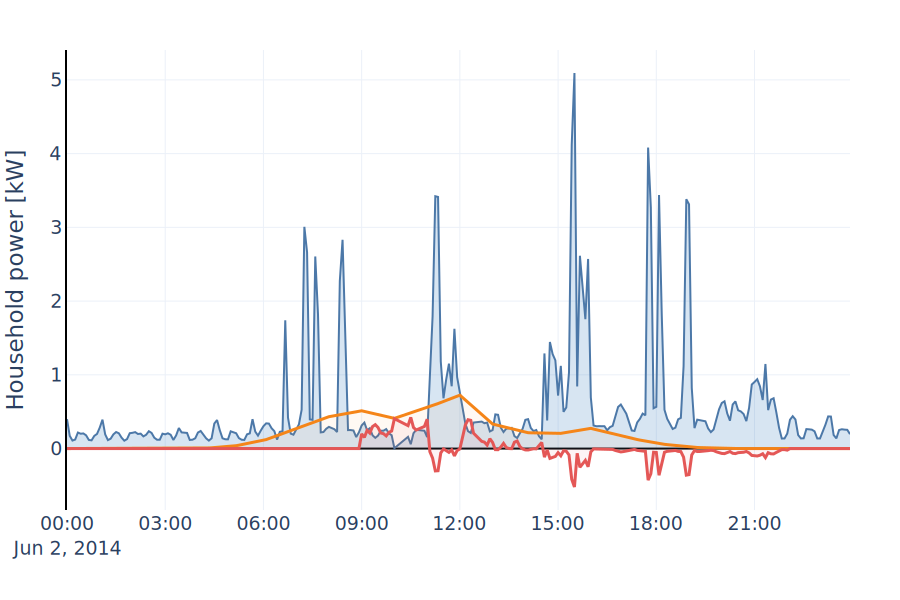

In [17]:
scenario = df.copy()
scenario.pv_1kw *= 1
scenario["storage"] = 0
scenario.loc["2014-06-02 09:00:00":"2014-06-02 22:00:00", "storage"] = (
    scenario.loc["2014-06-02 09:00:00":"2014-06-02 22:00:00", "pv_1kw"] 
    - scenario.loc["2014-06-02 09:00:00":"2014-06-02 22:00:00", "house7_kW"]
)
coef = -scenario["storage"].clip(lower=0).sum() / scenario["storage"].clip(upper=0).sum()
mask = scenario["storage"] < 0
scenario.loc[mask, "storage"] = 0.9 * coef * scenario.loc[mask, "storage"]

fig = px.line(scenario)
fig.data[0].update(fill="tozeroy", line_width=2,
                   fillcolor="rgba(55, 128, 191, 0.2)")
fig.data[1].update(fill="tozeroy", line_width=3,
                   fillcolor="rgba(255, 127, 14, 0.05)")
fig.data[2].update(fill="tozeroy", line_width=3,
                   fillcolor="rgba(214, 39, 40, 0.05)")
fig.update_layout(
    layout,
    height=600,
    width=900,
    showlegend=False,
    xaxis_title="",
    yaxis_title="Household power [kW]",
    yaxis_showline=True, yaxis_linewidth=2, yaxis_linecolor='black',
    xaxis_showline=False, xaxis_linewidth=2, xaxis_linecolor='black')
fig.show()

In [49]:
fig.write_image("results/self_suff_test_day2.svg")

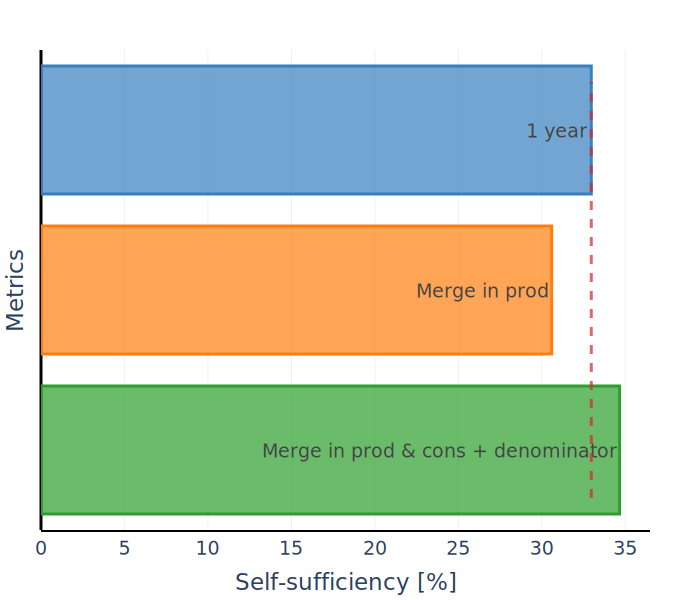

In [18]:
index = ["1 year", "Merge in prod",
         "Merge in prod & cons + denominator"]
funcs = [self_production_1year, def1_self_production,
         def3_self_production]
result = {"self-production": [], "self-consumption": []}
for func in funcs:
    res = func(scenario, "house7_kW", "pv_1kw", "storage")
    result["self-production"].append(res["self_prod"])
    result["self-consumption"].append(res["self_cons"])

result.update({"name": index})    
graph = pd.DataFrame(index=[3, 2, 1], data=result)
#graph = graph.sort_index(ascending=False)
fig = px.bar(graph[["name", "self-production"]],
             x="self-production", text="name", color="name",
             orientation="h")
colors = [("rgba(55, 128, 191, 1.0)", "rgba(55, 128, 191, 0.7)"), 
          ("rgba(255, 127, 14, 1.0)", "rgba(255, 127, 14, 0.7)"),
         ("rgba(44, 160, 44, 1.0)", "rgba(44, 160, 44, 0.7)")]
for i, color in enumerate(colors):
    fig.data[i].update(
        {'marker': {'color': color[1],
                    'line': {'width': 3,
                    'color': color[0]}}})

fig.add_shape(
  type='line',
  x0=graph.loc[3, "self-production"], x1=graph.loc[3, "self-production"],
  y0=0.7, y1=3.3,
  line={'dash': 'dash', 'width': 3,
        'color': 'rgba(214, 39, 40, 0.7)'})
fig.update_layout(
    layout,
    height=600,
    width=700,
    showlegend=False,
    xaxis_title="Self-sufficiency [%]", xaxis_dtick=5,
    yaxis_title="Metrics", yaxis_dtick=10,
    xaxis_showline=True, xaxis_linewidth=2, xaxis_linecolor='black',
    yaxis_showline=False, xaxis_zerolinewidth=3,
)
fig.show()